## 너무 많은 학습때문에 실용성이 떨어져 forward만 시켜봄으로써 성능측정을 해보겠다.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import random
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from pytorch_forecasting.metrics import SMAPE
from captum.attr import IntegratedGradients,NoiseTunnel

/home/sjlee/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. 모델 구성하기

In [2]:
data = pd.read_csv('./TrafficData/1-Copy1.csv')
data = data['volumn']
sequence_length = 1440
pred_len = 1

In [3]:
from torch import FloatTensor as FloatTensor

In [4]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    for i in range(len(x)-sequence_length-pred_len):
        seq_list.append(x.iloc[i:i+sequence_length].values)
        target_list.append(x.iloc[i+sequence_length:i+sequence_length+pred_len].values)

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)

In [5]:
split = 10080

In [6]:
seed = 42

In [7]:
device = torch.device("cuda:0")

In [8]:
X_test = torch.FloatTensor(data.iloc[-split-sequence_length:-split].values).to(device)
# X_train의 마지막 인덱스에서 sequece_length만큼 뒤에 부분을 잘라오기
X_test = X_test.view(1,1,sequence_length)

In [9]:
target = data.iloc[-split]
target = FloatTensor([target]).view(-1,1)
target

tensor([[2802986.]])

### 이번에는 forward만 시켜서 성능을 확인해보기 위해서 모델을 조정했다.

In [10]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq_len = 1440
        self.pred_len = 1
        #self.train_index = train_index
        self.first_layer = nn.Linear(self.seq_len,self.pred_len)
        self.first_layer.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
    def forward(self,x):
        return self.first_layer(x) 

# 2. Train-Validation set으로 쪼개기

In [11]:
data

0        2755201
1        2756000
2        2755897
3        2755301
4        2756166
          ...   
38875    2789520
38876    2788218
38877    2789770
38878    2788755
38879    2788395
Name: volumn, Length: 38880, dtype: int64

* 10080개는 test set 
* 28800개 중 0.2의 비율인 1440*4 = 5760개는 validation set
* 28800개 중 0.8의 비율인 28800-5760 = 23040개는 train set

In [12]:
train = data.iloc[:-split-5760]
val = data.iloc[-split-5760:-split]
x_train,y_train = seq_data(train,sequence_length=1440,pred_len=1)
x_val,y_val = seq_data(val,sequence_length=1440,pred_len=1)
train_dataset = TensorDataset(x_train,y_train)
val_dataset = TensorDataset(x_val,y_val)
training = DataLoader(train_dataset,batch_size=64)
validation = DataLoader(val_dataset,batch_size=64)

/tmp/ipykernel_184759/4291513198.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)


In [13]:
next(iter(validation))[0].size()

torch.Size([64, 1, 1440])

In [14]:
import torch

In [15]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed) # 난수 선언(원래는 cnt선언 위에 있었다)
minimal_loss = 200
train_index = np.arange(1440)
model = Model().to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
criterion = SMAPE()
num_epochs = 100
n= len(training)

### 기본 모델 training
* 모델클래스는 mutable한 객체이므로 모델을 copy할때 DeepCopy를 해줘야한다.
* copy모듈의 deepcopy를 사용

In [16]:
import copy

In [17]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for inputs, labels in training:
        # forward pass
        inputs = inputs[:,:,train_index]
        outputs = model(inputs)
        
        outputs = outputs.view(-1,1)
        labels = labels.view(-1,1)
        # defining loss
        loss = criterion(outputs, labels)
        # zero the parameter gradients
        optimizer.zero_grad()
        # computing gradients
        loss.backward()
        # accumulating running loss
        running_loss += loss.item()
        # updated weights based on computed gradients
        optimizer.step()
    if (running_loss/n)*100<minimal_loss:
        best_model = copy.deepcopy(model)
        minimal_loss = (running_loss/n)*100
        print("changed")
    
    if epoch % 20 == 0:    
        print('Epoch [%d]/[%d] running accumulative loss across all batches: %.3f' %(epoch + 1, num_epochs, (running_loss/n)*100))
    running_loss = 0.0

changed
Epoch [1]/[100] running accumulative loss across all batches: 1.550
changed
changed
Epoch [21]/[100] running accumulative loss across all batches: 1.686
Epoch [41]/[100] running accumulative loss across all batches: 1.324
changed
Epoch [61]/[100] running accumulative loss across all batches: 1.434
Epoch [81]/[100] running accumulative loss across all batches: 2.099


In [18]:
model = best_model

### validation set에 대해서 attribution 구하기

In [19]:
n = len(validation)
n

68

In [20]:
cnt = 0
ig = IntegratedGradients(model)
nt_ig = NoiseTunnel(ig)
nt_ig_attr_score = torch.zeros((1,1440))
for val in validation:
    temp_n = val[0].size(0)
    temp = nt_ig.attribute(val[0]).sum(axis = 0) # axis=0으로 batch axis를 기준으로 다 더했음
    nt_ig_attr_score = nt_ig_attr_score.to(device)+temp
    cnt = cnt + temp_n
nt_ig_attr_score = nt_ig_attr_score/cnt
nt_ig_attr_score = nt_ig_attr_score.cpu().numpy().reshape(-1)

In [21]:
len(nt_ig_attr_score)

1440

<AxesSubplot: >

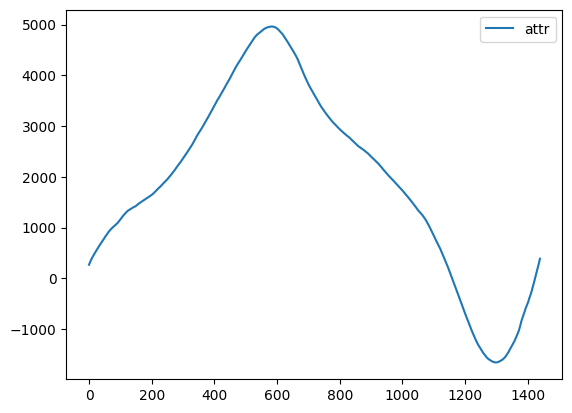

In [22]:
attr_df = pd.DataFrame({'attr':nt_ig_attr_score})
attr_df.plot()

### outlier가 감쇄 됐음을 확인할 수 있다.

#### scaling

In [23]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
attr_df = scaler.fit_transform(attr_df.values)
attr_df = pd.DataFrame({"attr":attr_df.reshape(-1)})
attr_df

,attr
0,-0.864456
1,-0.857164
2,-0.848835
3,-0.841429
4,-0.833567
...,...
1435,-0.860495
1436,-0.846331
1437,-0.831258
1438,-0.815716


#### train_index구하기

In [24]:
index_list = []
for hyper_parameter in np.arange(0.01,1.01,0.01):
    append_idx = list(attr_df[(attr_df['attr']>hyper_parameter) | (attr_df['attr']<-hyper_parameter)].index)
    index_list.append(append_idx)
len(index_list) # train_index의 리스트

100

In [25]:
len_list=[]
for i in range(100):
    len_list.append(len(index_list[i]))


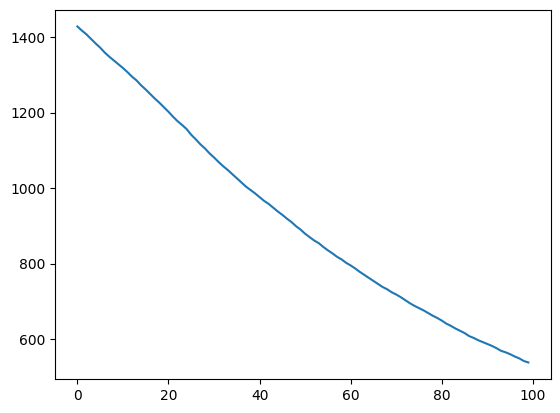

In [26]:
plt.plot(np.arange(100),len_list) # 포함되는 time_index의 갯수

In [27]:
for val_x,val_y in validation:
    print(val_x,val_y)

tensor([[[2796723., 2797804., 2797755.,  ..., 2801658., 2803101., 2801166.]],

        [[2797804., 2797755., 2797568.,  ..., 2803101., 2801166., 2799554.]],

        [[2797755., 2797568., 2796800.,  ..., 2801166., 2799554., 2799881.]],

        ...,

        [[2794154., 2794044., 2794871.,  ..., 2798282., 2797734., 2797158.]],

        [[2794044., 2794871., 2795820.,  ..., 2797734., 2797158., 2796599.]],

        [[2794871., 2795820., 2794320.,  ..., 2797158., 2796599., 2798303.]]],
       device='cuda:0') tensor([[[2799554.]],

        [[2799881.]],

        [[2800790.]],

        [[2800803.]],

        [[2800713.]],

        [[2800685.]],

        [[2801527.]],

        [[2801293.]],

        [[2800512.]],

        [[2800479.]],

        [[2800530.]],

        [[2799355.]],

        [[2799549.]],

        [[2799119.]],

        [[2799878.]],

        [[2800577.]],

        [[2799074.]],

        [[2799797.]],

        [[2799311.]],

        [[2799278.]],

        [[2799274.]],

     

tensor([[[2799040., 2800760., 2799420.,  ..., 2797444., 2798254., 2799268.]],

        [[2800760., 2799420., 2800770.,  ..., 2798254., 2799268., 2799729.]],

        [[2799420., 2800770., 2800382.,  ..., 2799268., 2799729., 2798621.]],

        ...,

        [[2817256., 2817948., 2818663.,  ..., 2810552., 2810764., 2811961.]],

        [[2817948., 2818663., 2819033.,  ..., 2810764., 2811961., 2811029.]],

        [[2818663., 2819033., 2820018.,  ..., 2811961., 2811029., 2811936.]]],
       device='cuda:0') tensor([[[2799729.]],

        [[2798621.]],

        [[2800071.]],

        [[2800242.]],

        [[2800876.]],

        [[2800205.]],

        [[2801061.]],

        [[2800778.]],

        [[2802492.]],

        [[2801785.]],

        [[2801512.]],

        [[2801656.]],

        [[2802305.]],

        [[2801790.]],

        [[2800925.]],

        [[2801006.]],

        [[2803110.]],

        [[2804494.]],

        [[2803506.]],

        [[2802084.]],

        [[2803577.]],

     

       device='cuda:0') tensor([[[2831550.]],

        [[2831976.]],

        [[2831701.]],

        [[2831579.]],

        [[2832377.]],

        [[2830845.]],

        [[2831087.]],

        [[2830977.]],

        [[2830573.]],

        [[2831439.]],

        [[2831443.]],

        [[2831928.]],

        [[2831238.]],

        [[2831348.]],

        [[2831810.]],

        [[2833343.]],

        [[2831647.]],

        [[2831638.]],

        [[2831173.]],

        [[2830826.]],

        [[2830793.]],

        [[2830933.]],

        [[2830405.]],

        [[2830354.]],

        [[2829911.]],

        [[2830068.]],

        [[2831051.]],

        [[2831158.]],

        [[2831983.]],

        [[2832358.]],

        [[2830421.]],

        [[2831630.]],

        [[2831356.]],

        [[2831270.]],

        [[2830778.]],

        [[2829052.]],

        [[2830670.]],

        [[2829491.]],

        [[2831367.]],

        [[2831254.]],

        [[2831127.]],

        [[2829535.]],

        [[

       device='cuda:0') tensor([[[2789942.]],

        [[2789883.]],

        [[2791505.]],

        [[2791145.]],

        [[2791158.]],

        [[2791007.]],

        [[2791103.]],

        [[2790819.]],

        [[2790249.]],

        [[2791953.]],

        [[2791040.]],

        [[2790522.]],

        [[2790427.]],

        [[2791219.]],

        [[2789942.]],

        [[2790667.]],

        [[2790586.]],

        [[2791636.]],

        [[2789990.]],

        [[2791376.]],

        [[2790125.]],

        [[2789791.]],

        [[2789334.]],

        [[2790056.]],

        [[2789753.]],

        [[2789469.]],

        [[2789498.]],

        [[2790237.]],

        [[2790568.]],

        [[2789499.]],

        [[2789747.]],

        [[2790547.]],

        [[2790055.]],

        [[2790361.]],

        [[2789887.]],

        [[2789927.]],

        [[2790005.]],

        [[2789925.]],

        [[2790407.]],

        [[2789302.]],

        [[2789797.]],

        [[2788709.]],

        [[

       device='cuda:0') tensor([[[2814851.]],

        [[2816130.]],

        [[2815567.]],

        [[2817571.]],

        [[2816619.]],

        [[2816806.]],

        [[2816629.]],

        [[2817800.]],

        [[2817869.]],

        [[2818113.]],

        [[2817021.]],

        [[2817455.]],

        [[2817907.]],

        [[2817361.]],

        [[2816993.]],

        [[2816109.]],

        [[2818308.]],

        [[2817649.]],

        [[2816997.]],

        [[2818484.]],

        [[2818028.]],

        [[2817059.]],

        [[2816842.]],

        [[2815220.]],

        [[2817051.]],

        [[2816255.]],

        [[2817364.]],

        [[2816084.]],

        [[2816826.]],

        [[2817164.]],

        [[2817910.]],

        [[2816954.]],

        [[2818546.]],

        [[2818117.]],

        [[2818926.]],

        [[2817086.]],

        [[2816862.]],

        [[2817436.]],

        [[2816646.]],

        [[2818425.]],

        [[2818551.]],

        [[2817755.]],

        [[

tensor([[[2799990., 2800397., 2800065.,  ..., 2792159., 2792670., 2792469.]],

        [[2800397., 2800065., 2799806.,  ..., 2792670., 2792469., 2793097.]],

        [[2800065., 2799806., 2799601.,  ..., 2792469., 2793097., 2793701.]],

        ...,

        [[2798699., 2798247., 2797694.,  ..., 2791941., 2790587., 2790771.]],

        [[2798247., 2797694., 2798028.,  ..., 2790587., 2790771., 2791033.]],

        [[2797694., 2798028., 2796532.,  ..., 2790771., 2791033., 2792336.]]],
       device='cuda:0') tensor([[[2793097.]],

        [[2793701.]],

        [[2793555.]],

        [[2793620.]],

        [[2793751.]],

        [[2792860.]],

        [[2793895.]],

        [[2793169.]],

        [[2793344.]],

        [[2793164.]],

        [[2793432.]],

        [[2792318.]],

        [[2792604.]],

        [[2790903.]],

        [[2792230.]],

        [[2791540.]],

        [[2790719.]],

        [[2792385.]],

        [[2791810.]],

        [[2790515.]],

        [[2791874.]],

     

       device='cuda:0') tensor([[[2788786.]],

        [[2788380.]],

        [[2789186.]],

        [[2789768.]],

        [[2788611.]],

        [[2788665.]],

        [[2790563.]],

        [[2790025.]],

        [[2790949.]],

        [[2789599.]],

        [[2790413.]],

        [[2789181.]],

        [[2789954.]],

        [[2790636.]],

        [[2790425.]],

        [[2790090.]],

        [[2790753.]],

        [[2792009.]],

        [[2792900.]],

        [[2791330.]],

        [[2792148.]],

        [[2792777.]],

        [[2791550.]],

        [[2791946.]],

        [[2792123.]],

        [[2792815.]],

        [[2792565.]],

        [[2792647.]],

        [[2791982.]],

        [[2792397.]],

        [[2791618.]],

        [[2792605.]],

        [[2791470.]],

        [[2790760.]],

        [[2789578.]],

        [[2790751.]],

        [[2790619.]],

        [[2791734.]],

        [[2791860.]],

        [[2792516.]],

        [[2791944.]],

        [[2792786.]],

        [[

tensor([[[2818889., 2819098., 2818688.,  ..., 2850858., 2851563., 2850787.]],

        [[2819098., 2818688., 2818400.,  ..., 2851563., 2850787., 2850936.]],

        [[2818688., 2818400., 2815998.,  ..., 2850787., 2850936., 2851274.]],

        ...,

        [[2817538., 2816669., 2816644.,  ..., 2843347., 2842347., 2843092.]],

        [[2816669., 2816644., 2817409.,  ..., 2842347., 2843092., 2843231.]],

        [[2816644., 2817409., 2817411.,  ..., 2843092., 2843231., 2843202.]]],
       device='cuda:0') tensor([[[2850936.]],

        [[2851274.]],

        [[2853252.]],

        [[2853077.]],

        [[2851244.]],

        [[2852978.]],

        [[2851241.]],

        [[2850252.]],

        [[2853015.]],

        [[2850864.]],

        [[2851449.]],

        [[2850120.]],

        [[2851074.]],

        [[2851242.]],

        [[2849296.]],

        [[2847504.]],

        [[2848693.]],

        [[2847157.]],

        [[2849908.]],

        [[2847695.]],

        [[2848003.]],

     

In [28]:
val_x

tensor([[[2793782., 2791816., 2791590.,  ..., 2805477., 2807247., 2804741.]],

        [[2791816., 2791590., 2792746.,  ..., 2807247., 2804741., 2805965.]],

        [[2791590., 2792746., 2791385.,  ..., 2804741., 2805965., 2806690.]],

        ...,

        [[2790771., 2791033., 2792336.,  ..., 2805795., 2804113., 2803545.]],

        [[2791033., 2792336., 2792659.,  ..., 2804113., 2803545., 2805464.]],

        [[2792336., 2792659., 2791127.,  ..., 2803545., 2805464., 2805264.]]],
       device='cuda:0')

In [29]:
m = len(validation)
n = len(training)
cnt = 0
out_list = []
num_epochs = 100
criterion = SMAPE()
for idx in index_list: #0.01~1.00 100개의 index에 대해서 수행
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed) # 난수 선언(원래는 cnt선언 위에 있었다)
    train_idx = idx
    result = 0
    pred = torch.FloatTensor().to(device)
    val_target = torch.FloatTensor().to(device)
    for val_x,val_y in validation:
        val_x[:,:,train_idx] = 0 # 이렇게 수행함으로써 forward되지 않도록
        tmp_pred = model(val_x)
        pred = torch.concat([pred,tmp_pred], dim=0)
        val_target = torch.concat([val_target,val_y],dim = 0)
    pred = pred.view(-1,1)
    val_target = val_target.view(-1,1)
    result = criterion(pred,val_target).item()*100
    out_list.append(result)

In [30]:
out_df = pd.DataFrame({"out":out_list})

<AxesSubplot: >

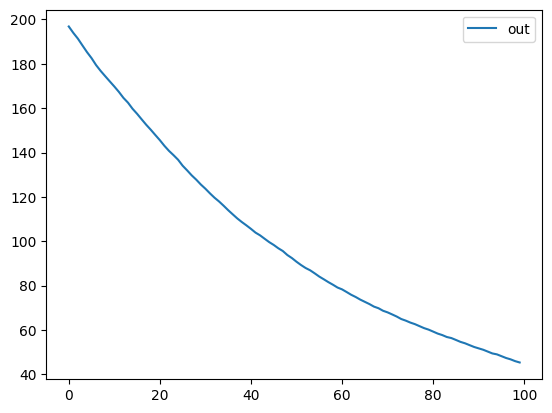

In [31]:
out_df.plot()

In [32]:
index_list[9] # 9번째 out에 대한 index_list

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [33]:
out_df.head(10)

,out
0,196.804452
1,193.914771
2,191.326094
3,188.264906
4,185.251200
5,182.542634
6,179.391217
7,176.770115
8,174.402845
9,172.064519


In [34]:
out_df.min()

out    45.353451
dtype: float64

### core_idx 정의

In [35]:
core_idx = out_df[out_df['out']==out_df.min().item()].index.item()
core_idx

99

## mid Result
* loss가 계속 갑소하는 것으로 확인할 수 있다.

## 최솟값을 갖는 지점으로 training 시켜봐서 결과 확인
&rightarrow; 0을 넣음으로써 검증할수도 있겠지만 확실하게 검증을 위해 이전에 쓰던 모델을 정의

In [36]:
class Model(nn.Module):
    def __init__(self,train_index):
        super().__init__()
        self.seq_len = len(train_index)
        self.pred_len = 1
        self.train_index = train_index
        self.first_layer = nn.Linear(self.seq_len,self.pred_len)
        self.first_layer.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
    def forward(self,x):
        return self.first_layer(x[:,:,self.train_index]) 

In [37]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed) # 난수 선언(원래는 cnt선언 위에 있었다)
minimal_loss = 200
train_idx = index_list[core_idx]
model = Model(train_idx).to(device) # 모델 초기화
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) # optimizer 초기화
criterion = SMAPE()
num_epochs = 100
n= len(training)
result = 0
for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for inputs, labels in training:
        # forward pass
        inputs = inputs
            
        outputs = model(inputs)
        outputs = outputs.view(-1,1)
        labels = labels.view(-1,1)
        # defining loss
        loss = criterion(outputs, labels)
        # zero the parameter gradients
        optimizer.zero_grad()
        # computing gradients
        loss.backward()
        # accumulating running loss
        running_loss += loss.item()
        # updated weights based on computed gradients
        optimizer.step()
    if epoch == 99:    
        print(f'{cnt}번째 모델 Training 완료 마지막 Epoch loss:{(running_loss/n)*100}')
    if (running_loss/n)*100<minimal_loss:
        best_model = copy.deepcopy(model)
        minimal_loss = (running_loss/n)*100
        print("changed")

model = best_model
    
pred = torch.FloatTensor().to(device)
val_target = torch.FloatTensor().to(device)
for val_x,val_y in validation:
    tmp_pred = model(val_x)
    pred = torch.concat([pred,tmp_pred], dim=0)
    val_target = torch.concat([val_target,val_y],dim = 0)
pred = pred.view(-1,1)
val_target = val_target.view(-1,1)
result = criterion(pred,val_target).item()*100
result

changed
changed
changed
changed
0번째 모델 Training 완료 마지막 Epoch loss:2.878870908997556


1.423495914787054

## Result
* SAMPLE1의 최솟값은 0.806748
* 매우좋은 성능을 가지고 있음을 확인할 수 있다.
* 왼쪽 성능이 비교적 좋은 성능을 갖고 있음을 확인할 수 있다.<br>
&rightarrow;**output값에서 최솟값을 갖는다고 그 값이 무조건 최소는 아니다.**

In [38]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed) # 난수 선언(원래는 cnt선언 위에 있었다)
minimal_loss = 200
train_idx = index_list[core_idx-1]
model = Model(train_idx).to(device) # 모델 초기화
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) # optimizer 초기화
criterion = SMAPE()
num_epochs = 100
n= len(training)
result = 0
for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for inputs, labels in training:
        # forward pass
        inputs = inputs
            
        outputs = model(inputs)
        outputs = outputs.view(-1,1)
        labels = labels.view(-1,1)
        # defining loss
        loss = criterion(outputs, labels)
        # zero the parameter gradients
        optimizer.zero_grad()
        # computing gradients
        loss.backward()
        # accumulating running loss
        running_loss += loss.item()
        # updated weights based on computed gradients
        optimizer.step()
    if epoch == 99:    
        print(f'{cnt}번째 모델 Training 완료 마지막 Epoch loss:{(running_loss/n)*100}')
    if (running_loss/n)*100<minimal_loss:
        best_model = copy.deepcopy(model)
        minimal_loss = (running_loss/n)*100
        print("changed")

model = best_model
    
pred = torch.FloatTensor().to(device)
val_target = torch.FloatTensor().to(device)
for val_x,val_y in validation:
    tmp_pred = model(val_x)
    pred = torch.concat([pred,tmp_pred], dim=0)
    val_target = torch.concat([val_target,val_y],dim = 0)
pred = pred.view(-1,1)
val_target = val_target.view(-1,1)
result = criterion(pred,val_target).item()*100
result

changed
changed
changed
changed
0번째 모델 Training 완료 마지막 Epoch loss:1.526385174536204


1.3738355599343777